# Beijing Air Quality Forecasting Notebook

In [230]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.optimizers import SGD, Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping

In [231]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [232]:
# Load the train and test datasets
train = pd.read_csv('/content/drive/MyDrive/train.csv')
test = pd.read_csv('/content/drive/MyDrive/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [233]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [234]:
# Get all columns of our dataset
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [235]:
# Generate descriptive statistics for our dataset
train.describe()


,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,28755.000000
mean,15338.500000,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,0.016193,0.005833,-0.025008,100.793427
std,8855.542765,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,1.006001,1.001847,0.982122,93.144433
min,1.000000,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,0.000000
25%,7669.750000,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,29.000000
50%,15338.500000,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,75.000000
75%,23007.250000,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,1.448138,1.366085,-0.522096,142.000000
max,30676.000000,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,1.448138,1.366085,1.915355,994.000000


In [236]:
# Generate summary of dataframe
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  float64
 11  pm2.5     28755 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.8+ MB


In [237]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [238]:
# Chek dataset for missing values
train.isnull().sum()

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
cbwd_NW,0
cbwd_SE,0
cbwd_cv,0


In [239]:
# Fill missing values with mean
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


In [240]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30676 entries, 2010-01-01 00:00:00 to 2013-07-02 03:00:00
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       30676 non-null  int64  
 1   DEWP     30676 non-null  float64
 2   TEMP     30676 non-null  float64
 3   PRES     30676 non-null  float64
 4   Iws      30676 non-null  float64
 5   Is       30676 non-null  float64
 6   Ir       30676 non-null  float64
 7   cbwd_NW  30676 non-null  float64
 8   cbwd_SE  30676 non-null  float64
 9   cbwd_cv  30676 non-null  float64
 10  pm2.5    30676 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 2.8 MB


# Visualizations

In [241]:
# Drop No row(does not contribute to prediction)
train.drop(columns=['No'], inplace=True)

<Axes: title={'center': 'PM.2.5 levels over time'}, xlabel='datetime'>

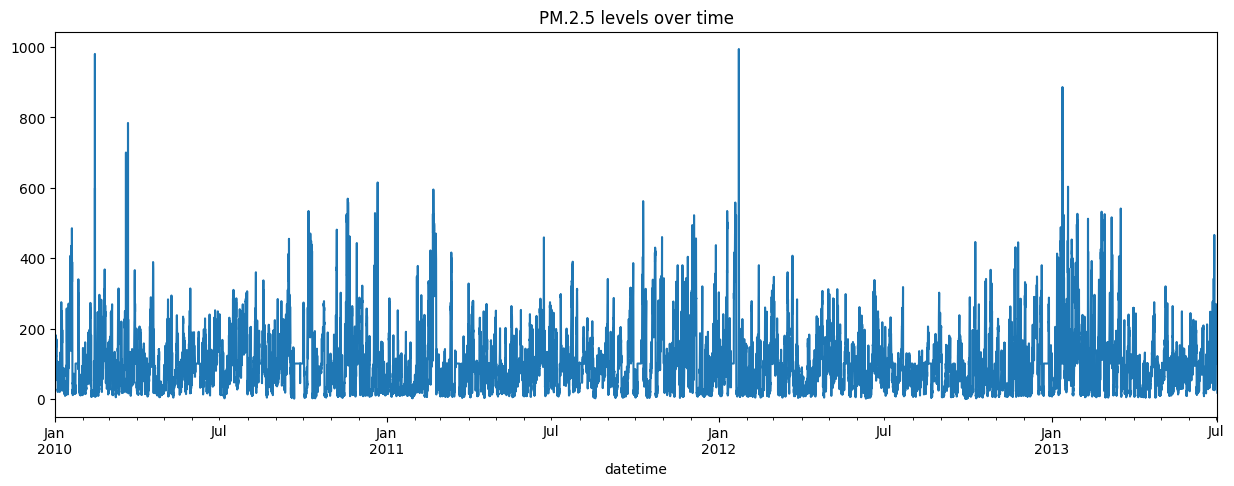

In [242]:
#PM2.5 Line plot over time
# This plot shows patterns of pm2.5 concentration over time and helps us observe trends and patterns
# The spikes or peaks indicate greatest amount of air pollution
train['pm2.5'].plot(figsize=(15, 5), title='PM.2.5 levels over time')

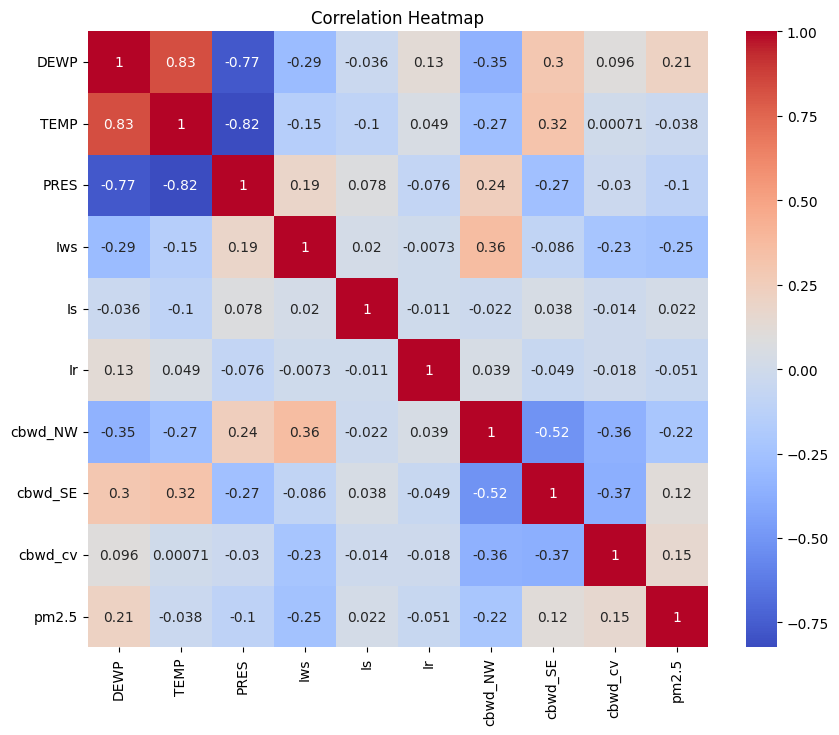

In [243]:
# correlation heatmap to help us understand the relationship between features and target(pm2.5)
# This will help in identifying useful predictors

corr = train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [244]:
X_train = train.drop(['pm2.5'], axis=1)
y_train = train['pm2.5']

In [245]:
# Reshape data for LSTM input by reshaping to add 'timesteps' dimension
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train = np.expand_dims(X_train, axis=1)

In [246]:
X_train.shape

(30676, 1, 9)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [247]:
# define model
model = Sequential([
    LSTM(32, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(16, activation='relu'),
    Dense(1)
])

optimizer = Adam(learning_rate=0.005)
# Compile the model
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# Display the model architecture
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_68 (LSTM)                  │ (None, 1, 32)          │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_69 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,529 (33.32 KB)

 Trainable params: 8,529 (33.32 KB)

 Non-trainable params: 0 (0.00 B)

In [248]:
# Train the model
# You can adjust the number of epochs and batch size to improve performance.

#Early stopping to monitor validation loss
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     restore_best_weights=True,
# )
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - lambda: 89.4347 - loss: 8845.7793
Epoch 2/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 71.7308 - loss: 5474.3003
Epoch 3/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 70.2179 - loss: 5194.2148
Epoch 4/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 69.3024 - loss: 5099.6621
Epoch 5/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - lambda: 70.1633 - loss: 5217.0386
Epoch 6/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 69.4638 - loss: 5129.0859
Epoch 7/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 69.1507 - loss: 5042.8188
Epoch 8/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - lambda: 68.7091 - loss: 5012.1602
Epoch 9/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 69.0631 - loss: 5065.4585
Epoch 10/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 69.2362 - loss: 5055.6226
Epoch 11/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 69.3363 - loss: 5052.4561
Epoch 12/50
959/959 ━━━━━━━━━━

959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


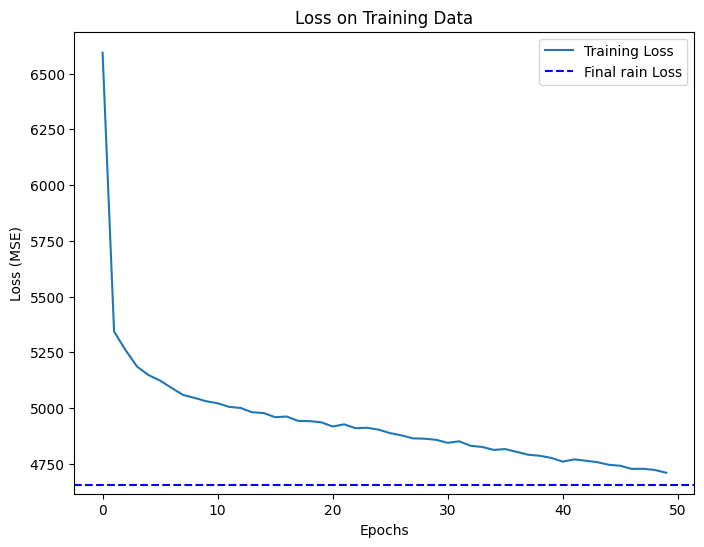

Final Training Loss (MSE): 4654.14904989335
Final training RMSE: 68.2213240115827


In [249]:
# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)
train_rmse = np.sqrt(train_loss)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")
print(f"Final training RMSE: {train_rmse}")

In [250]:
import os
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

output_dir = '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting'
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

output_path = os.path.join(output_dir, 'subm_fixed.csv')

# # Save the file in CSV format for submission on Kaggle
submission.to_csv(output_path, index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
